In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
#Load data
df = pd.read_csv('/Users/ellenwu/homework5-1/data/output/acs_medicaid.txt',delimiter='\t')

1. Plot the share of the adult population with direct purchase health insurance over time.

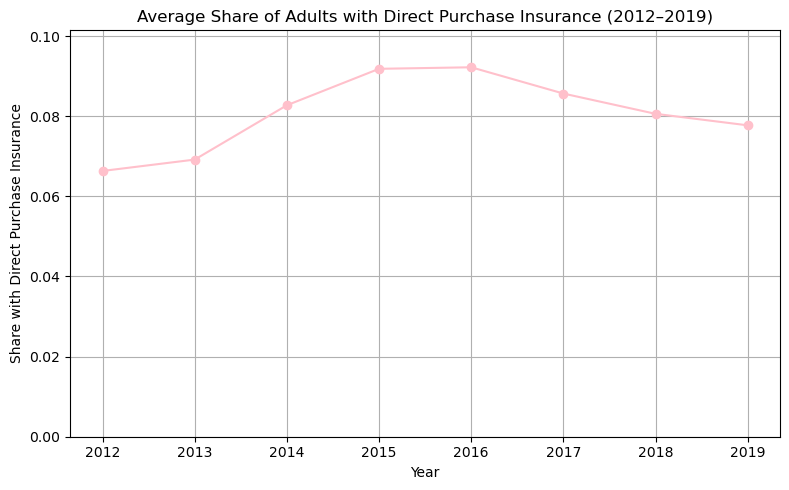

In [8]:
# Drop rows where adult population or direct insurance values are missing or zero
df = df[df['adult_pop'].notna() & df['ins_direct'].notna()]
df = df[df['adult_pop'] > 0]

# Calculate share of direct-purchase insurance
df['share_direct'] = df['ins_direct'] / df['adult_pop']

# Filter out any rows where the share is missing or invalid
df = df[df['share_direct'].notna() & df['share_direct'].apply(lambda x: x != float('inf'))]

# Group by year to calculate the average share
trend = df.groupby('year', as_index=False)['share_direct'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(trend['year'], trend['share_direct'], marker='o', linestyle='-', color='pink')
plt.title("Average Share of Adults with Direct Purchase Insurance (2012–2019)")
plt.xlabel("Year")
plt.ylabel("Share with Direct Purchase Insurance")
plt.ylim(0, trend['share_direct'].max() * 1.1 if not trend['share_direct'].isna().all() else 0.05)
plt.grid(True)
plt.xticks(ticks=trend['year'], labels=trend['year'])
plt.tight_layout()
plt.show()


2. Discuss the reduction in direct purchase health insurance in later years. Can you list a couple of policies that might have affected the success of the direct purchase insurance market?

In later years, the share of adults with direct-purchase health insurance declined after peaking during the initial rollout of the ACA exchanges. Two major policy changes likely contributed to this drop. First, the repeal of the individual mandate penalty in 2019 reduced the incentive for healthy individuals to purchase insurance, weakening risk pools. Second, the termination of cost-sharing reduction payments in 2017 led insurers to raise premiums, making plans less affordable for many. These shifts undermined the stability of the individual market and reduced participation.

3. Plot the share of the adult population with Medicaid over time.

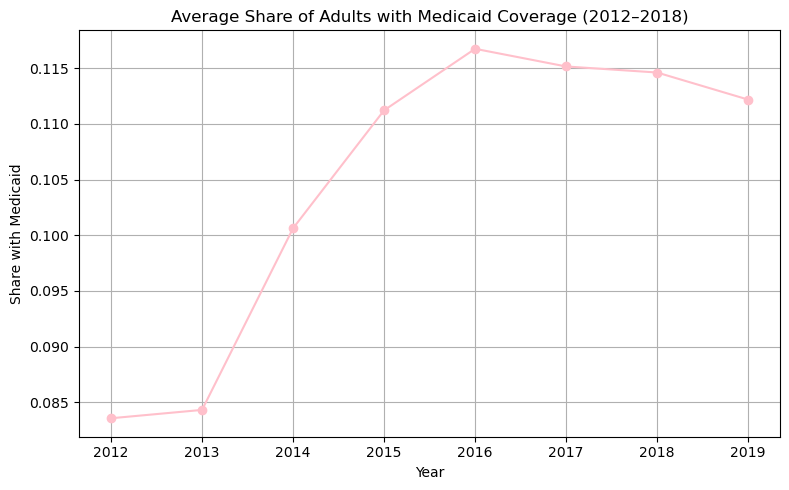

In [ ]:
# Calculate share of adult population with Medicaid
df['share_medicaid'] = df['ins_medicaid'] / df['adult_pop']

# Group by year and calculate average share
medicaid_trend = df.groupby('year', as_index=False)['share_medicaid'].mean()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(medicaid_trend['year'], medicaid_trend['share_medicaid'], marker='o', linestyle='-', color='Pink')
plt.title("Average Share of Adults with Medicaid Coverage (2012–2019)")
plt.xlabel("Year")
plt.ylabel("Share with Medicaid")
plt.grid(True)
plt.tight_layout()
plt.show()

4. Plot the share of uninsured over time, separately by states that expanded Medicaid in 2014 versus those that did not. Drop all states that expanded after 2014.

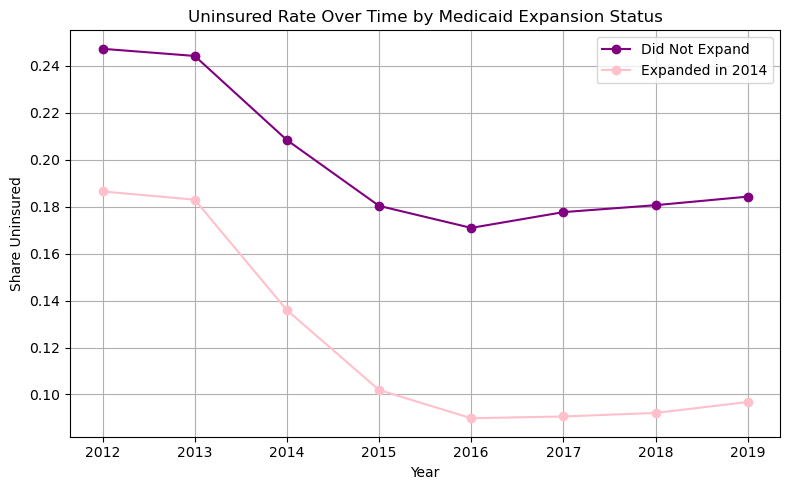

In [10]:
# Identify states that expanded in 2014 or never expanded
expansion_2014_states = df[df['expand_year'] == 2014]['State'].unique()
never_expanded_states = df[df['expand_ever'] == False]['State'].unique()

# Combine them into one list
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))

# Filter dataset
filtered_df = df[df['State'].isin(keep_states)].copy()

# Assign group labels explicitly
filtered_df['expansion_group'] = filtered_df['State'].apply(
    lambda x: 'Expanded in 2014' if x in expansion_2014_states else 'Did Not Expand'
)

# Group by year and expansion status, then average
uninsured_trend = (
    filtered_df.groupby(['year', 'expansion_group'])['uninsured']
    .sum()
    .div(filtered_df.groupby(['year', 'expansion_group'])['adult_pop'].sum())
    .reset_index(name='share_uninsured')
)

# Plot
plt.figure(figsize=(8, 5))

for label, grp in uninsured_trend.groupby('expansion_group'):
    color = 'pink' if label == 'Expanded in 2014' else 'purple'
    plt.plot(grp['year'], grp['share_uninsured'], marker='o', label=label, color=color)

plt.title("Uninsured Rate Over Time by Medicaid Expansion Status")
plt.xlabel("Year")
plt.ylabel("Share Uninsured")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

5. Calculate the average percent of uninsured individuals in 2012 and 2015, separately for expansion and non-expansion states. Present your results in a basic 2x2 DD table.

In [11]:
# Filter to 2012 and 2015
df_dd = df[df['year'].isin([2012, 2015])].copy()

# Keep only states that expanded in 2014 or never expanded
expansion_2014_states = df[df['expand_year'] == 2014]['State'].unique()
never_expanded_states = df[df['expand_ever'] == False]['State'].unique()
keep_states = list(set(expansion_2014_states).union(set(never_expanded_states)))
df_dd = df_dd[df_dd['State'].isin(keep_states)].copy()

# Assign treatment group
df_dd['group'] = df_dd['State'].apply(
    lambda x: 'Expanded' if x in expansion_2014_states else 'Not Expanded'
)

# Calculate average uninsurance rate by year and group
ate_table = (
    df_dd.groupby(['group', 'year'])[['uninsured', 'adult_pop']]
    .sum()
    .reset_index()
)

ate_table['uninsured_rate'] = ate_table['uninsured'] / ate_table['adult_pop']

# Pivot for 2x2 display
dd_pivot = ate_table.pivot(index='group', columns='year', values='uninsured_rate')
dd_pivot['Change'] = dd_pivot[2015] - dd_pivot[2012]

# DiD estimate
did_estimate = dd_pivot.loc['Expanded', 'Change'] - dd_pivot.loc['Not Expanded', 'Change']

# Display
print("\nQ5: Difference-in-Differences Table (Uninsurance Rates)")
print(dd_pivot)
print(f"\nEstimated ATE (Difference-in-Differences): {did_estimate:.4f}")


Q5: Difference-in-Differences Table (Uninsurance Rates)
year              2012      2015    Change
group                                     
Expanded      0.186524  0.101914 -0.084610
Not Expanded  0.247324  0.180381 -0.066943

Estimated ATE (Difference-in-Differences): -0.0177


6. Estimate the effect of Medicaid expansion on the uninsurance rate using a standard DD regression estimator, again focusing only on states that expanded in 2014 versus those that never expanded.

In [12]:
# Subset to relevant states
df_reg_all_years = df[df['State'].isin(keep_states)].copy()

# Create DiD variables
df_reg_all_years['treatment'] = df_reg_all_years['State'].apply(lambda x: 1 if x in expansion_2014_states else 0)
df_reg_all_years['post'] = df_reg_all_years['year'].apply(lambda x: 1 if x >= 2014 else 0)
df_reg_all_years['interaction'] = df_reg_all_years['treatment'] * df_reg_all_years['post']

# Calculate uninsured rate
df_reg_all_years['uninsured_rate'] = df_reg_all_years['uninsured'] / df_reg_all_years['adult_pop']

# Fit regression
model = smf.ols('uninsured_rate ~ treatment + post + interaction', data=df_reg_all_years).fit()

# Print results
print(model.summary())
print(f"\nEstimated ATE (DiD Regression across all years): {model.params['interaction']:.4f}")

                            OLS Regression Results                            
Dep. Variable:         uninsured_rate   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.502
Method:                 Least Squares   F-statistic:                     119.0
Date:                Wed, 23 Apr 2025   Prob (F-statistic):           4.80e-53
Time:                        09:01:22   Log-Likelihood:                 628.45
No. Observations:                 352   AIC:                            -1249.
Df Residuals:                     348   BIC:                            -1233.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.2140      0.007     30.564      

7. Include state and year fixed effects in your estimates. Try using the lfe or fixest package to estimate this instead of directly including the fixed effects.

In [14]:
# Filter for states that expanded in 2014 or never expanded
fe_df = df[df['State'].isin(keep_states)].copy()

# Create DiD variables
fe_df['treatment'] = fe_df['State'].isin(expansion_2014_states).astype(int)
fe_df['post'] = (fe_df['year'] >= 2014).astype(int)
fe_df['interaction'] = fe_df['treatment'] * fe_df['post']
fe_df['uninsured_rate'] = fe_df['uninsured'] / fe_df['adult_pop']

# Ensure no missing values in key columns
fe_df = fe_df.dropna(subset=['uninsured_rate', 'interaction'])

# Run DiD with fixed effects using categorical terms
model = smf.ols("uninsured_rate ~ interaction + C(State) + C(year)", data=fe_df).fit()

# Output
print(model.summary2().tables[1].loc[['interaction']])
print(f"\nEstimated ATE (DiD interaction effect): {model.params['interaction']:.4f}")

                Coef.  Std.Err.         t         P>|t|    [0.025    0.975]
interaction -0.018842   0.00348 -5.414798  1.259113e-07 -0.025689 -0.011994

Estimated ATE (DiD interaction effect): -0.0188


8. Repeat the analysis in question 7 but include all states (even those that expanded after 2014). Are your results different? If so, why?

In [17]:
# Copy full dataset
df_all = df.copy()

# Treatment: 1 if a state ever expanded Medicaid
df_all['treatment'] = df_all['expand_ever'].fillna(0).astype(int)

# Post: 1 if year >= expansion year (if applicable)
df_all['post'] = (df_all['year'] >= df_all['expand_year']).astype(int)

# DiD interaction
df_all['interaction'] = df_all['treatment'] * df_all['post']

# Outcome: uninsurance rate
df_all['uninsured_rate'] = df_all['uninsured'] / df_all['adult_pop']

# Drop missing or malformed data
df_all = df_all.dropna(subset=['uninsured_rate', 'interaction', 'State', 'year'])

# Estimate DiD with fixed effects using categorical variables
model_all = smf.ols("uninsured_rate ~ interaction + C(State) + C(year)", data=df_all).fit()

# Extract ATE and print only that
ate = model_all.params['interaction']
se = model_all.bse['interaction']
pval = model_all.pvalues['interaction']

print("\nQ8: DiD Regression with All States and Years Included (w/ FE)")
print(f"Estimated ATE (All States, w/ FE): {ate:.4f}")
print(f"Standard Error: {se:.4f}, p-value: {pval:.4f}")


Q8: DiD Regression with All States and Years Included (w/ FE)
Estimated ATE (All States, w/ FE): -0.0238
Standard Error: 0.0029, p-value: 0.0000


9. Provide an “event study” graph showing the effects of Medicaid expansion in each year. Use the specification that includes state and year fixed effects, limited to states that expanded in 2014 or never expanded.

In [18]:
keep_states = df[df['expand_year'].isin([2014, pd.NA])]['State'].unique()
es_df = df[df['State'].isin(keep_states)].copy()

es_df['event_time'] = es_df['year'] - es_df['expand_year']
# Set non-expansion states to NaN (so we can drop them later or plot separately if needed)
es_df.loc[es_df['expand_ever'] == False, 'event_time'] = None

# Drop rows with missing adult_pop or uninsured
es_df = es_df.dropna(subset=['adult_pop', 'uninsured'])

# Calculate outcome
es_df['uninsured_rate'] = es_df['uninsured'] / es_df['adult_pop']

# Keep years in a reasonable window (optional)
es_df = es_df[(es_df['event_time'] >= -5) & (es_df['event_time'] <= 5)]

In [19]:
# Replace negative years with 'pre' and positive with 'post'
for t in range(-5, 6):
    if t == 0:
        continue
    label = f"pre{abs(t)}" if t < 0 else f"post{t}"
    es_df[label] = (es_df['event_time'] == t).astype(int)

event_terms = ' + '.join([f"pre{abs(t)}" if t < 0 else f"post{t}" for t in range(-5, 6) if t != 0])
formula = f'uninsured_rate ~ {event_terms} + C(State) + C(year)'

event_model = smf.ols(formula=formula, data=es_df).fit()

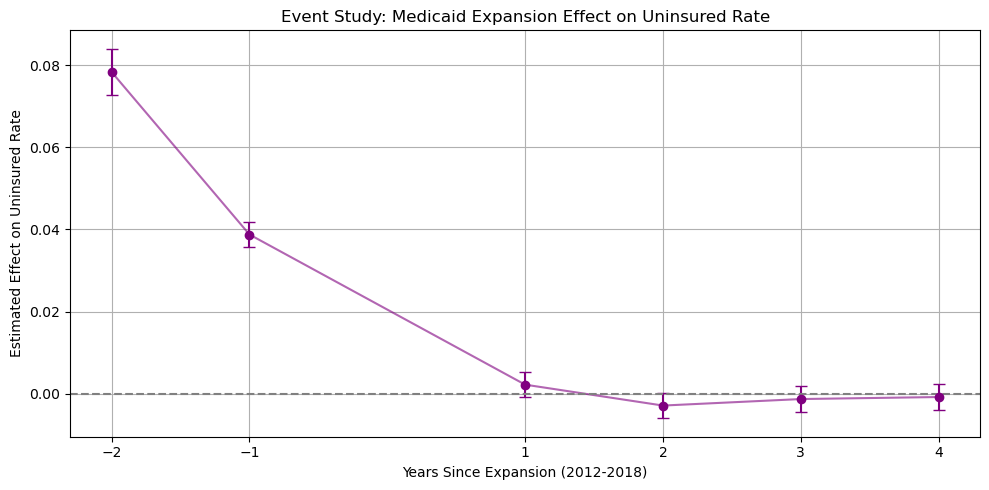

In [20]:
# Extract coefficients and CIs
years = [t for t in range(-2, 5) if t != 0]
labels = [f"pre{abs(t)}" if t < 0 else f"post{t}" for t in years]
coefs = [event_model.params.get(label, 0) for label in labels]
errors = [event_model.bse.get(label, 0) for label in labels]

# Plot error bars
plt.figure(figsize=(10, 5))
plt.errorbar(years, coefs, yerr=1.96 * pd.Series(errors), fmt='o', capsize=4, label="Point Estimate", color='purple')

# Plot connecting line
plt.plot(years, coefs, linestyle='-', color='purple', alpha=0.6)

# Add baseline and labels
plt.axhline(0, linestyle='--', color='gray')
plt.title("Event Study: Medicaid Expansion Effect on Uninsured Rate")
plt.xlabel("Years Since Expansion (2012-2018)")
plt.ylabel("Estimated Effect on Uninsured Rate")
plt.xticks(years)
plt.grid(True)
plt.tight_layout()
plt.show()

10. Repeat part 9 but again include states that expanded after 2014. Note: this is tricky…you need to put all states onto “event time” to create this graph.

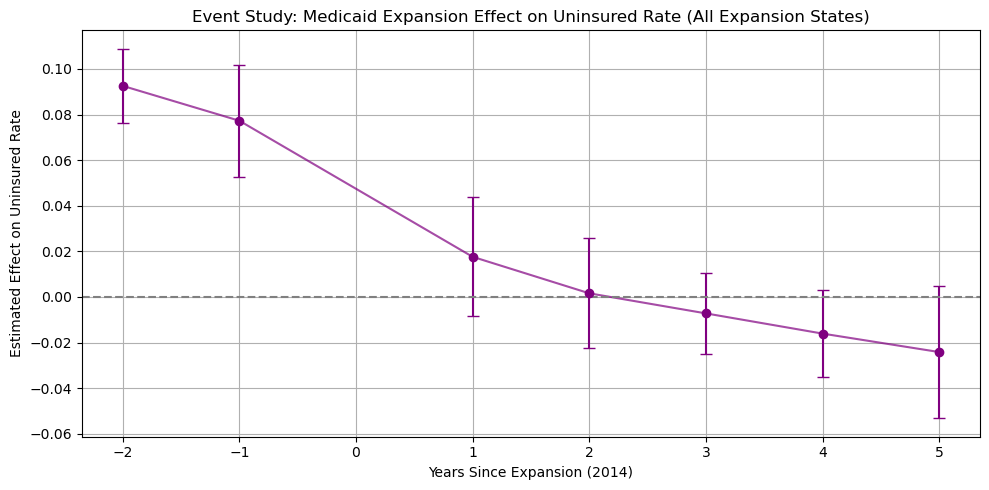

In [23]:
# Keep only event_time between -2 and 5 (inclusive), drop event_time == 0
es_df = df[df['expand_ever'] == True].copy()
es_df['event_time'] = es_df['year'] - es_df['expand_year']
es_df = es_df[(es_df['event_time'] >= -2) & (es_df['event_time'] <= 5)]
es_df = es_df[es_df['event_time'] != 0]

# Create event-time dummies
for i in range(-2, 6):  # Note: upper bound is 6 to include 5
    if i == 0:
        continue
    label = f'event_m{abs(i)}' if i < 0 else f'event_p{i}'
    es_df[label] = (es_df['event_time'] == i).astype(int)

# Create outcome variable
es_df["uninsured_rate"] = es_df["uninsured"] / es_df["adult_pop"]

# Build regression formula
event_terms = ' + '.join([
    f'event_m{abs(i)}' if i < 0 else f'event_p{i}' 
    for i in range(-2, 6) if i != 0
])
formula = f'uninsured_rate ~ {event_terms} + C(State) + C(year)'

# Run regression
event_model = smf.ols(formula=formula, data=es_df).fit()

# Extract coefficients
coefs = event_model.params.filter(like='event_')
cis = event_model.conf_int().loc[coefs.index]
errors = (cis[1] - cis[0]) / 2

# Create event year labels
def parse_event_label(name):
    if "m" in name:
        return -int(name.split("m")[1])
    else:
        return int(name.split("p")[1])

event_years = [parse_event_label(name) for name in coefs.index]

plot_df = pd.DataFrame({
    'event_year': event_years,
    'coef': coefs.values,
    'stderr': errors.values
}).sort_values('event_year')

# Plot
plt.figure(figsize=(10, 5))
plt.errorbar(plot_df['event_year'], plot_df['coef'], yerr=1.96 * plot_df['stderr'],
             fmt='o', capsize=4, color='purple')
plt.plot(plot_df['event_year'], plot_df['coef'], linestyle='-', color='purple', alpha=0.7)
plt.axhline(0, linestyle='--', color='gray')
plt.title("Event Study: Medicaid Expansion Effect on Uninsured Rate (All Expansion States)")
plt.xlabel("Years Since Expansion (2014)")
plt.ylabel("Estimated Effect on Uninsured Rate")
plt.grid(True)
plt.tight_layout()
plt.show()